# News Category Classification using Transformers

## 1. Load & Inspect the Dataset

### 1.1 Load the Dataset

In [4]:
import pandas as pd


DATA_PATH = "/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json"

df = pd.read_json(DATA_PATH, lines=True)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### 1.2 Remove Invalid Rows

In [5]:
df = df.dropna(subset=["category"])

df["headline"] = df["headline"].fillna("")
df["short_description"] = df["short_description"].fillna("")

print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (209527, 6)


### 1.3 Create Final Text Column and Sanity Check

In [6]:
df["text"] = df["headline"].str.strip() + " " + df["short_description"].str.strip()

df = df[df["text"].str.strip() != ""]

df[["category", "text"]].head()


print("Number of categories:", df["category"].nunique())

df["category"].unique()[:10]

df["text"].str.len().describe()

Number of categories: 42


count    209522.000000
mean        173.628144
std          78.549381
min           4.000000
25%         123.000000
50%         171.000000
75%         208.000000
max        1487.000000
Name: text, dtype: float64

## 2. Exploratory Data Analysis (EDA)

### 2.1 Category Distribution

In [7]:
import matplotlib.pyplot as plt

category_counts = df["category"].value_counts()

print(category_counts.head())
print(category_counts.tail())

category
POLITICS          35601
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: count, dtype: int64
category
ARTS & CULTURE    1339
COLLEGE           1144
LATINO VOICES     1130
CULTURE & ARTS    1074
EDUCATION         1014
Name: count, dtype: int64


### 2.2 Visualize Class Imbalance

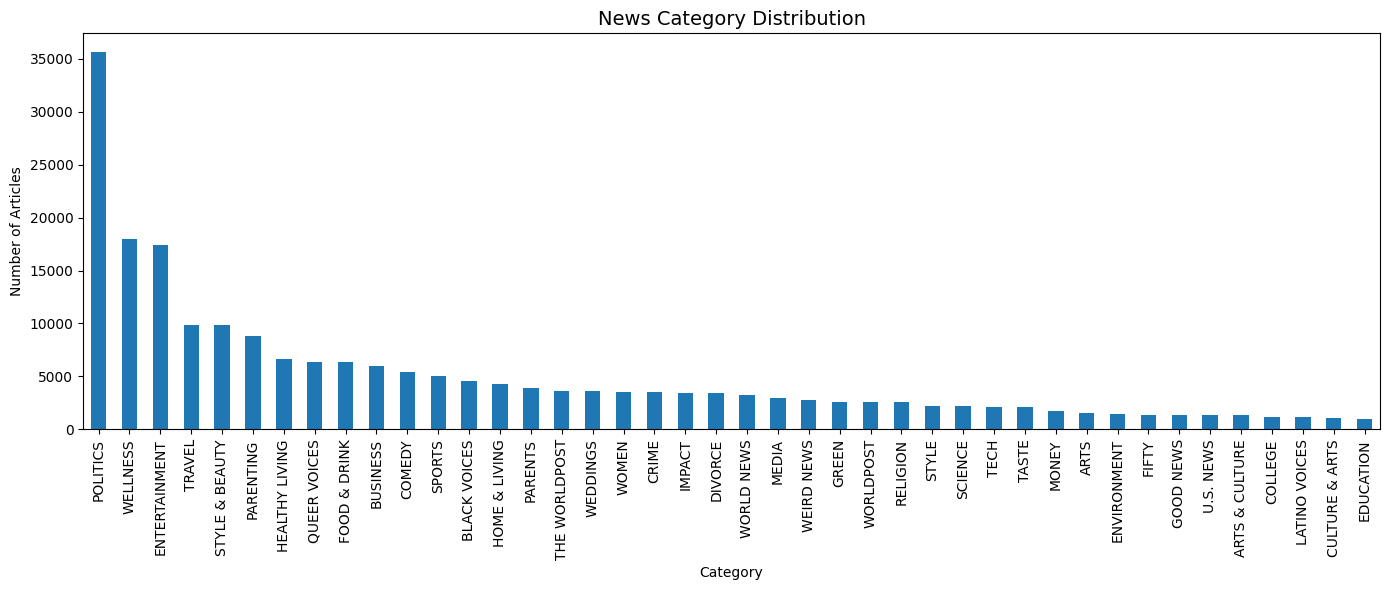

In [8]:
import matplotlib.pyplot as plt
import os

OUTPUT_DIR = "figures"
os.makedirs(OUTPUT_DIR, exist_ok=True)

category_counts = df["category"].value_counts()

plt.figure(figsize=(14, 6))
category_counts.plot(kind="bar")
plt.title("News Category Distribution", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plot_path = os.path.join(OUTPUT_DIR, "category_distribution.png")
plt.savefig(plot_path, dpi=300)
plt.close()

### 2.3 Identify Rare Categories

In [9]:
rare_categories = category_counts[category_counts < 1000]

print(f"Number of rare categories (<1000 samples): {len(rare_categories)}")

print("Top 5 categories cover:",
      category_counts.head(5).sum() / len(df) * 100, "% of data")

Number of rare categories (<1000 samples): 0
Top 5 categories cover: 43.2517826290318 % of data


## 3. Label Encoding and Stratified Train/Val/Test Split

### 3.1 Encode Category Labels

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df["label"] = label_encoder.fit_transform(df["category"])

num_labels = len(label_encoder.classes_)
print("Number of classes:", num_labels)

label_mapping = dict(zip(label_encoder.classes_, range(num_labels)))
label_mapping

Number of classes: 42


{'ARTS': 0,
 'ARTS & CULTURE': 1,
 'BLACK VOICES': 2,
 'BUSINESS': 3,
 'COLLEGE': 4,
 'COMEDY': 5,
 'CRIME': 6,
 'CULTURE & ARTS': 7,
 'DIVORCE': 8,
 'EDUCATION': 9,
 'ENTERTAINMENT': 10,
 'ENVIRONMENT': 11,
 'FIFTY': 12,
 'FOOD & DRINK': 13,
 'GOOD NEWS': 14,
 'GREEN': 15,
 'HEALTHY LIVING': 16,
 'HOME & LIVING': 17,
 'IMPACT': 18,
 'LATINO VOICES': 19,
 'MEDIA': 20,
 'MONEY': 21,
 'PARENTING': 22,
 'PARENTS': 23,
 'POLITICS': 24,
 'QUEER VOICES': 25,
 'RELIGION': 26,
 'SCIENCE': 27,
 'SPORTS': 28,
 'STYLE': 29,
 'STYLE & BEAUTY': 30,
 'TASTE': 31,
 'TECH': 32,
 'THE WORLDPOST': 33,
 'TRAVEL': 34,
 'U.S. NEWS': 35,
 'WEDDINGS': 36,
 'WEIRD NEWS': 37,
 'WELLNESS': 38,
 'WOMEN': 39,
 'WORLD NEWS': 40,
 'WORLDPOST': 41}

### 3.2 Save Label Mappings

In [11]:
import json
import os

os.makedirs("artifacts", exist_ok=True)

label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

with open("artifacts/label2id.json", "w") as f:
    json.dump(label2id, f, indent=2)

with open("artifacts/id2label.json", "w") as f:
    json.dump(id2label, f, indent=2)

print("Label mappings saved to artifacts/")

Label mappings saved to artifacts/


### 3.3 Prepare Features & Labels

In [12]:
X = df["text"].values
y = df["label"].values

### 3.4 Stratified Train / Validation / Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,      
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,      
    stratify=y_temp,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 146665
Validation size: 31428
Test size: 31429


## 4. Tokenization (DistilBERT)

### 4.1 Choose Model & Tokenizer

In [14]:
from transformers import DistilBertTokenizerFast

MODEL_NAME = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### 4.2 Create Hugging Face Datasets

In [15]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "text": X_train,
    "label": y_train
})

val_dataset = Dataset.from_dict({
    "text": X_val,
    "label": y_val
})

test_dataset = Dataset.from_dict({
    "text": X_test,
    "label": y_test
})

### 4.3 Tokenize the splits

In [16]:
MAX_LENGTH = 128

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/146665 [00:00<?, ? examples/s]

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/31429 [00:00<?, ? examples/s]

### 4.4 Set PyTorch Format

In [17]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

## 5. Model Setup & Training

### 5.1 Load the Model

In [18]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=42,
    id2label=id2label,
    label2id=label2id
)

2025-12-23 11:06:48.122427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766488008.305905      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766488008.361566      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766488008.811895      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766488008.811933      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766488008.811936      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Compute Class Weights

In [19]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

### 5.3 Custom Trainer with Weighted Loss

In [20]:
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


### 5.4 Define Metrics

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

### 5.5 Training Arguments

In [22]:
pip install --upgrade transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 122.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
Note: you may need to restart the kernel to use updated packages.


In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",           
    save_strategy="steps",           
    eval_steps=2700,                  
    save_steps=2700,                  
    learning_rate=2e-5,
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,               
    load_best_model_at_end=True,     
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"                 
)


### 5.6 Initialize Trainer

In [24]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

### 5.7 Training

In [25]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
2700,1.598400,1.600711,0.555428,0.480207,0.539572,0.482504
5400,1.496200,1.401659,0.604620,0.512380,0.593484,0.533524
8100,1.484400,1.310833,0.614929,0.522614,0.619211,0.550096
10800,1.180600,1.286649,0.637712,0.542871,0.626743,0.571001
13500,1.033700,1.281352,0.645475,0.550390,0.626439,0.575306
16200,1.090400,1.247850,0.641848,0.544448,0.637322,0.575736
18900,0.903900,1.255194,0.654989,0.559778,0.634944,0.587094
21600,0.768600,1.275954,0.649135,0.556552,0.638360,0.586496
24300,0.842800,1.274074,0.656485,0.561267,0.638371,0.589475
27000,0.838600,1.273712,0.657057,0.563463,0.639991,0.591890


TrainOutput(global_step=27501, training_loss=1.189408897638347, metrics={'train_runtime': 3208.6292, 'train_samples_per_second': 137.129, 'train_steps_per_second': 8.571, 'total_flos': 1.458164256899328e+16, 'train_loss': 1.189408897638347, 'epoch': 3.0})

### 5.8 Save the Final Model

In [26]:
trainer.save_model("./final_model")